# CLASIFICADOR DE MEMES


---
**Por Antonio Miranda A01611795**

**INTRODUCCION**

---
Este proyecto tiene como objetivo poder diferenciar entre imagenes con cierta tematica, en este caso Memes. Esto tiene aplicaciones a la hora de analizar grupos o fandoms que generan contenido dentro de redes sociales como facebook, instagram. De esta forma podemos clasificar a que fandom pertenece cada imagen.

---
**DATASET**

---
Para cumplir con esta tarea haremos uso de un dataset de 1500 imagenes(al rededor de 1.2GB) de distintas resoluciones. Compuesto principalmente de memes, fan art y imagenes de dos videojuegos, Doom y Animal Crossing.

Link del dataset en kaggle: https://www.kaggle.com/datasets/andrewmvd/doom-crossing

Este dataset cumple con 4 Vs para poder llamarlo Big Data:


*   Volumen: El DataSet contiene un gran volumen de imagenes (1500) por lo que usar herramientas como pyspark facilita su procesamiento.
*   Velocidad: Al ser un dataset compuesto principalmente por imagenes creadas en foros y grupos de fandoms, se suben imagenes nuevas en todo momento, por lo que se requiere mucha velocidad para procesar las imagenes.
*   Variedad:  El DataSet trata de memes, que por si solos son de una naturaleza muy diversa tocando diferentes temas relacionados a los fandoms y los grupos donde se comparten.
*   Valor: El DataSet puede darnos un mejor entendimineto de las comunidad online, anlizar las tendencias y potencialmente enfocar una audiencia o generar mas contenido.

---
**PYSPARK Y MODELOADO**

---
Considerando el tamano del dataset y sus especificaciones usaremos Pyspark para entrenar un modelo sencillo de forma rapida. Para este caso ocuparemos una regresion logistica.


## PYSPARK SETUP

---
Implementamos la ultima version de pyspark y le asignamos 8 gb de memoria para poder procesar el dataset sin quedarnos sin espacio.

In [16]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3//spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark
!pip install MLLib

#Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

#Probando PySparl
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

# Agregamos 8g de memoria para poder procesar el  DataSet completo.
spark = SparkSession \
       .builder \
       .appName("SparkTraining") \
       .config("spark.driver.memory", "8g") \
       .getOrCreate()

spark

# Otras librerias que usare
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
import numpy as np
import cv2

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
49 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

## Drive Import
---
El dataset se encuentra en la nube (Google Drive) por lo que para acceder a el hay que dar permisos al notebook para acceder a las carpetas con las imagenes

In [17]:
# add my Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load DataSet
---
Creamos una funcion que nos permita acceder a nuestras imagenes, las redimensione y les aplique un flatten para convertirlas en un vector de 1 dimension. Este proceso se repite para cada imagen y despues lo entrega en un arreglo. Hacemos esto para cada carpeta(Clase) y despues las juntamos un solo DataFrame de pyspark.

Esto lo hacemos para poder trabajar con los datos de forma distribuida, transformamos las imagenes para poder pasarlas por la regresion logistica, ya que esta como tal no ve imagenes sino los valores de cada pixel.

In [18]:
def load_images(folder,label):
  data=[]
  for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
    if img is not None:
      img = cv2.resize(img, (32, 32))  # Redimensiona para uniformidad
      img = img.flatten()  # Aplana la imagen a un vector de 1D
      data.append((Vectors.dense(img), label))
  return data

In [19]:
doom= load_images("/content/drive/MyDrive/Ismael/doom",label=0)
animalCrossing= load_images("/content/drive/MyDrive/Ismael/animal_crossing",label=1)

data = doom + animalCrossing
df = spark.createDataFrame(data, ["features", "label"])


In [20]:
# Save df to a csv
df.toPandas().to_csv("/content/drive/MyDrive/Ismael/data.csv", index=False)


### Visualizacion del DataSet
---
Para mejorar el entendimiento de nuestros datos y conocer la estructura del DataSet graficamos cuantos elementos hay en cada clase.

---

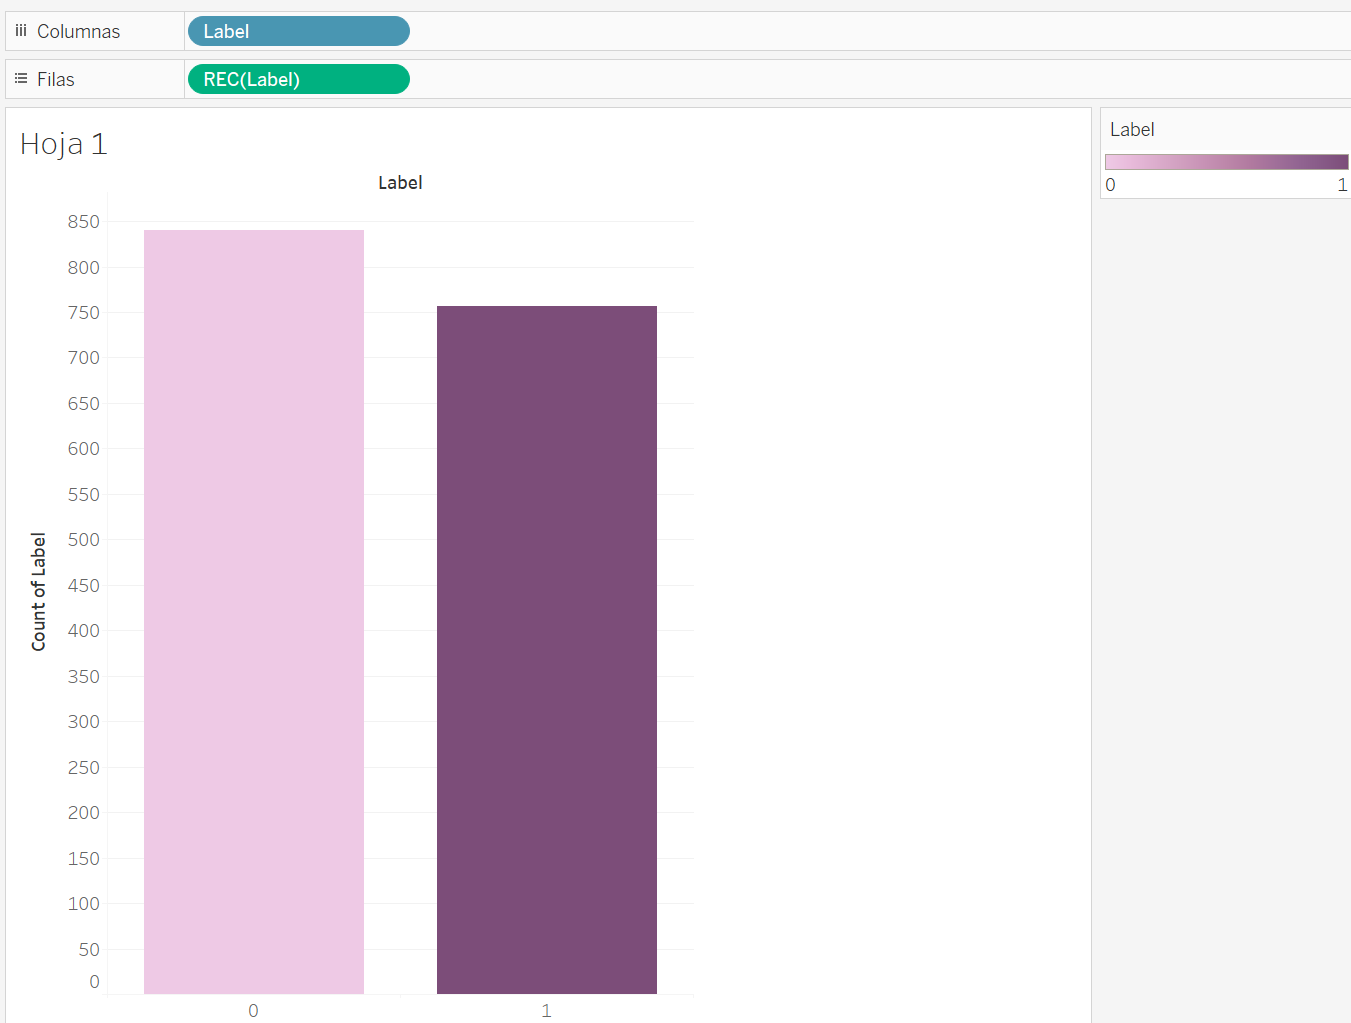

---
De lo que nos podemos dar cuent es que nuestro DataSet esta ligeramente desvalanceado, lo que podria ocacionar un sesgo hacia cierta clase o identificacion, para solucionar esto podriamos agregar mas imagenes a la clase desvalanceada o agregar mas clases para que el algoritmo no se especialice en una sola clase.

---
## Modelo
---
Instanciamos dos modelos simples aprovechando el poder computacional que nos brinda pyspark para poder comparar las  imagenes. Una regresion logistica y un random forest.

**El preprosesado** de los datos lo hacemos realizando un escalamiento de las caracteristicas usando standarScaler y luedo reduciendo la dimensionalidad usando PCA. Esto prepara los datos para su uso en la regresion logistica.

In [21]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

pca = PCA(k=50, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(df)
df = pca_model.transform(df)

**Hacemos el Split** de los datos, aunque hay una gran cantidad de imagenes, la diversidad variedad de estas hace que sea viable tener un 20% de los datos para Test y un 80% de estos en entrenamiento. adicional a esto usamos un 20% de estos datos tambien para validad los resultados del entrenamiento. Esto lo hacemos con el proposito de evaluar el modelo y saber si los resultados que nos otorga son viables

In [22]:
# split
train, test = df.randomSplit([0.8, 0.2], seed=42)
validation= train.randomSplit([0.8, 0.2], seed=42)

**Instanciamos el modelo** una regresion logistica y lo ponemos a entrenar, con 20 iteraciones como maximo, ya que puede darse el caso en que mas iteraciones no genere una mejora significativa, de modo que si se estanca en el proceso de entrenamiento este se detendra.

In [23]:
lr = LogisticRegression(featuresCol="pcaFeatures", labelCol="label", maxIter=20)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

rfmodel= rf.fit(train)
lrmodel = lr.fit(train)

## Evaluacion del Modelo
---
Una vez el modelo ya haya sido entrenado tocara evaluarlo para saber si este nos puede generar valor. Para esto hacemos uso de diferentes metricas como, accuracy, F1, precision, recall, auc roc. Estas metricas nos permiten conocer el desempeno del modelo en un ambiente mas realista y nos permiten decidir cual de los dos modelos a comparar es mejor.

In [24]:
predictions = lrmodel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
precision = precision_evaluator.evaluate(predictions)
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
recall = recall_evaluator.evaluate(predictions)
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_roc = binary_evaluator.evaluate(predictions)
pr_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
auc_pr = pr_evaluator.evaluate(predictions)


In [25]:
import pandas as pd

# Example metrics
metrics_data = {
    "Metric": ["Accuracy", "F1 Score", "Precision", "Recall", "AUC-ROC", "AUC-PR"],
    "Score": [accuracy, f1_score, precision, recall, auc_roc, auc_pr]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("/content/drive/MyDrive/Ismael/lr_metrics.csv", index=False)

In [26]:
predictions = rfmodel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
precision = precision_evaluator.evaluate(predictions)
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
recall = recall_evaluator.evaluate(predictions)
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_roc = binary_evaluator.evaluate(predictions)
pr_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
auc_pr = pr_evaluator.evaluate(predictions)


In [27]:
import pandas as pd

# Example metrics
metrics_data = {
    "Metric": ["Accuracy", "F1 Score", "Precision", "Recall", "AUC-ROC", "AUC-PR"],
    "Score": [accuracy, f1_score, precision, recall, auc_roc, auc_pr]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("/content/drive/MyDrive/Ismael/rf_metrics.csv", index=False)

### Resultados
---
Despues de graficar los resultados de las metricas en ambos modelos obtenemos que el random forest se comporto mejor para clasificar imagenes, ya que sus metricas promedian alrededor del 75% mientras que la regresion logistica promedia al rededor del 65%.


---

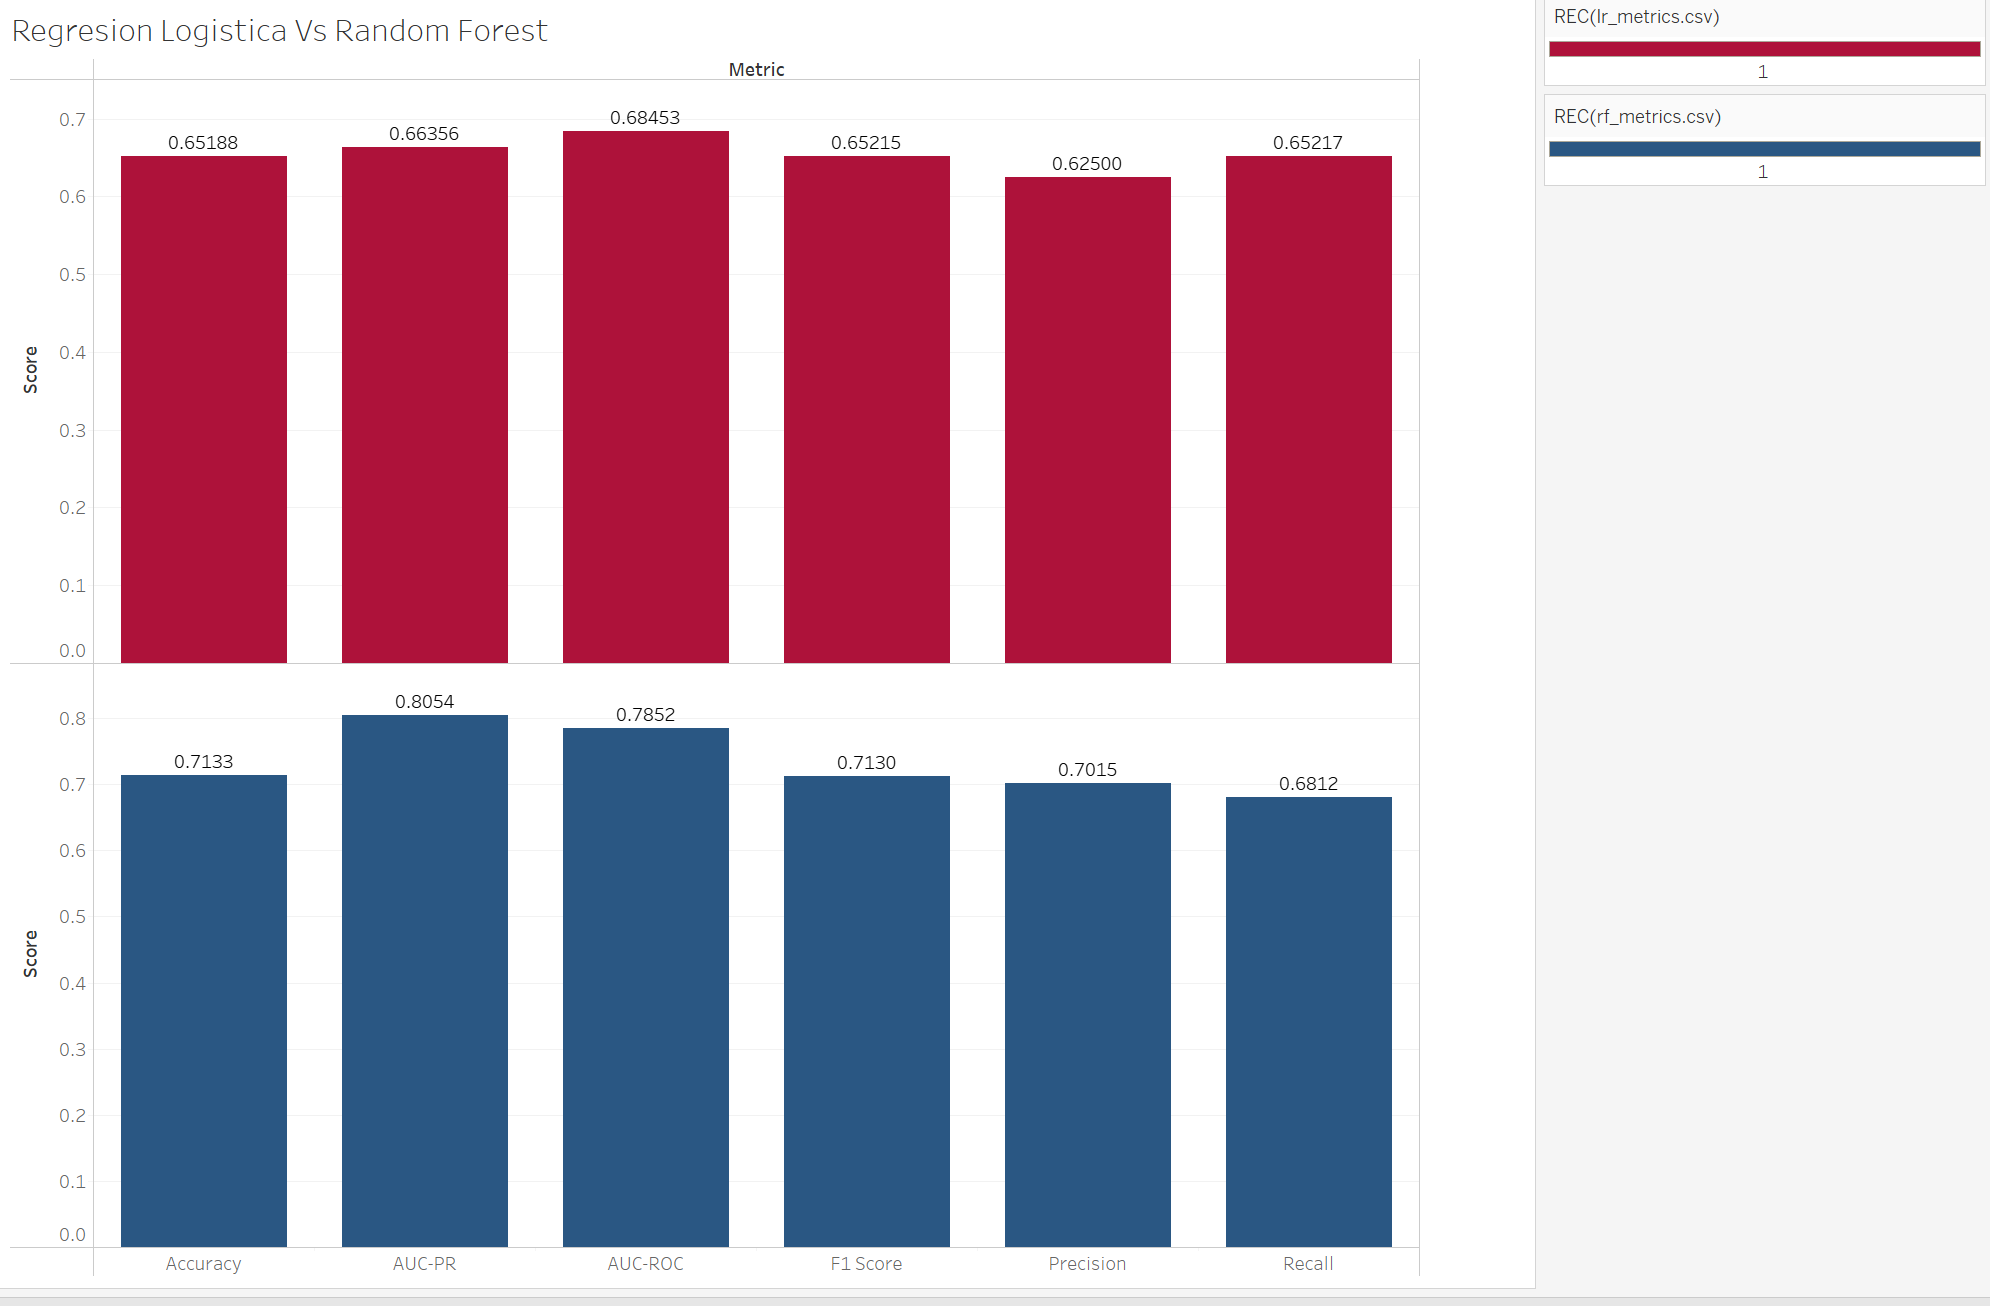

In [28]:
spark.stop()